# Libraries

In [556]:
import os 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn import datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from imutils import contours
sns.set()

# Import data

In [546]:
data_path = os.getcwd() + str('/Dataset/') #check adress if not working /Dataset/
df = pd.DataFrame()

for file in glob.glob(data_path + '*.csv'):
    head, tail = os.path.split(file)
    file_name = tail
    current = pd.read_csv(file, sep = ";")
    current["name"] = file_name
    df = pd.concat([df, current],axis=0)

df = df.drop(df.columns[[0]], axis=1)
df.head()

,used_liter,image,name
0,33,e104664ba1792dde641d87cd5d95f1df06786140.jpg,HQ_quality.csv
1,29,48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg,HQ_quality.csv
2,230,9e111802446b62b86aeffe911415ad28227caba7.jpg,HQ_quality.csv
3,43,f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg,HQ_quality.csv
4,51,62e96bf40409b3b6fd74065ab0bf3ec44f9d0a61.jpg,HQ_quality.csv


# Exploratory Data Analysis

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

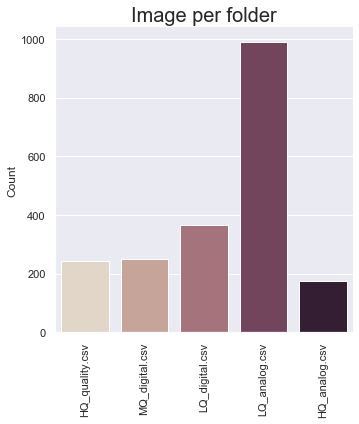

In [3]:
# image per folder
sns.catplot(x="name", kind="count", palette="ch:.25", data=df);
plt.title('Image per folder', fontsize = 20, fontweight = 20)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

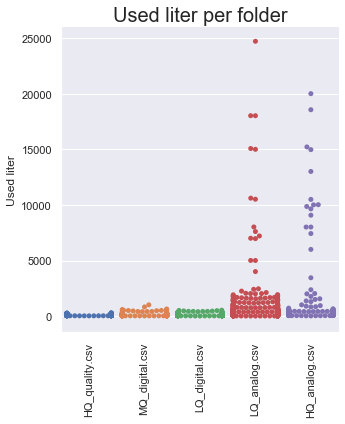

In [4]:
# used liter per folder
sns.catplot(x="name", y="used_liter", kind="swarm", data=df);
plt.title('Used liter per folder', fontsize = 20, fontweight = 20)
plt.xlabel('')
plt.ylabel('Used liter')
plt.xticks(rotation=90)

In [5]:
# divide into train and test
# import images - or at least find a way to loop through
# constrast
# basic algorithm
# performance evaluation - easy data to compare with
# include business point of view - how to implement 
# goal of the project
# presentation outline 
# tasks for digit recognition
# tasks for optimisation

In [38]:
data_path = os.getcwd() + str('/Dataset') #+ str('/HQ_analog')
data_path

'/Users/michaelallouche/Google Drive/Git/Eleven_study/Dataset'

### Create classifier

In [106]:
dataset = datasets.fetch_openml('mnist_784', version=1, cache=True)

In [109]:
features = np.array(dataset.data, 'int16') 
labels = np.array(dataset.target, 'int')

list_hog_fd = []

for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')

In [112]:
clf = LinearSVC()
clf.fit(hog_features, labels)
joblib.dump(clf, "digits_cls.pkl", compress=3)

['digits_cls.pkl']

### Iterate through images

In [548]:
data_path = os.getcwd() + str('/Dataset/') + str('LQ_analog')#check adress if not working /Dataset/
df = pd.DataFrame()

for file in glob.glob(data_path + '*.csv'):
    head, tail = os.path.split(file)
    file_name = tail
    current = pd.read_csv(file, sep = ";")
    current["name"] = file_name
    df = pd.concat([df, current],axis=0)

df_names = df[['image']]
data_path + str('/') + df_names.values[13].tolist()[0]

'/Users/michaelallouche/Google Drive/Git/Eleven_study/Dataset/LQ_analog/2248efe519ce5eea0924d62e7241201a5664ad32.jpg'

7747.4

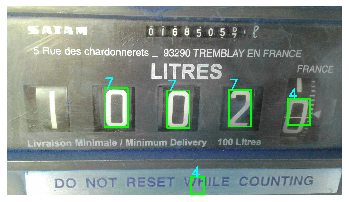

In [578]:
def number_prediction(image):
    
    im = cv2.imread(data_path + str('/') + df_names.values[image].tolist()[0])
    
    try:
        # Convert to grayscale and apply Gaussian filtering
        grayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        (thresh, im_th) = cv2.threshold(grayImage, 150, 255, cv2.THRESH_BINARY)
    except:
        return None
        
    # Find contours in the image
    ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get rectangles contains each contour
    #rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    rects = []
    test = []
    digits = []
    
    ctrs = contours.sort_contours(ctrs,method='left-to-right')[0]

    for ctr in ctrs:
        (x, y, w, h) = cv2.boundingRect(ctr)
        if (w >= 10 and w <= 300) and (h >= 100 and h <= 500):  
             rects.append(cv2.boundingRect(ctr))

    for rect in rects:
        # Draw the rectangles
        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 10) 
        # Make the rectangular region around the digit
        leng = int(rect[3] * 1.1)
        larg = int(rect[3] * 1.1)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = im_th[pt1:pt1 + leng, pt2:pt2 + leng]
        test.append(roi)

        try:
            # Resize the image
            roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
            roi = cv2.dilate(roi, (3, 3))
        
        except:
            return None

        # Calculate the HOG features
        roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
        nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
        cv2.putText(im, str(int(nbr[0])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 3, (0, 255, 255), 5)
        digits.append(nbr[0])
        
        if len(digits) == 5:
 
            #print(test[1])
            plt.imshow(test[0])
            plt.imshow(im)
            plt.axis('off')
            cv2.waitKey()

        
            return(float("{}{}{}{}.{}".format(*digits)))
    
number_prediction(15)
#"{}{}{}{}.{}".format(*number_prediction(15))

[None, None, None, 1982.8, None, None, 7176.7, None, 9924.7, None]

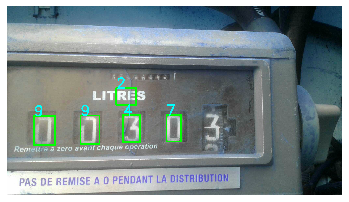

In [603]:
data_path = os.getcwd() + str('/Dataset/') + str('HQ_analog') #check adress if not working /Dataset/
df = pd.DataFrame()

for file in glob.glob(data_path + '*.csv'):
    head, tail = os.path.split(file)
    file_name = tail
    current = pd.read_csv(file, sep = ";")
    current["name"] = file_name
    df = pd.concat([df, current],axis=0)

df_names = df[['image']]
df_liter = df[['used_liter']]

predictions = []
for i in range(10):
    predictions.append(number_prediction(i))
    
predictions

In [601]:
df_final = pd.DataFrame(predictions)
df_final.rename(columns={0:'pred'},inplace=True)
round(df_final)
pd.concat([df_final,df_liter])

/Users/michaelallouche/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,pred,used_liter
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,1982.8,NaN
4,NaN,NaN
...,...,...
171,NaN,200.0
172,NaN,270.0
173,NaN,126.0
174,NaN,280.0


In [ ]:
import os 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
sns.set()

data_path = os.getcwd() + str('/Dataset/') #check adress if not working /Dataset/
df = pd.DataFrame()

for file in glob.glob(data_path + '*.csv'):
    head, tail = os.path.split(file)
    file_name = tail
    current = pd.read_csv(file, sep = ";")
    current["name"] = file_name
    df = pd.concat([df, current],axis=0)

df_names = df[['image']]

pred_list = []
for i in range(10):
    pred = number_prediction(df_names.values[i].tolist()[0]) # number_prediction is the function that predicts the numbers
    pred_list.append(pred)
    
df_pred = pd.DataFrame(pred)
df_pred.rename(columns={0:'predictions'}, inplace = True)

df_liter = df[['used_liter']]

df_final = pd.concat([df_pred,df_liter],axis=1)
accuracy = 100 * len(df_final[df_final['predictions']==df_final['used_liter']])/len(df_final)

In [ ]:
pred_list = []
for i in range(10):
    pred = number_prediction(df_names.values[i].tolist()[0]) # number_prediction is the function that predicts the numbers
    pred_list.append(pred)
    
df_pred = pd.DataFrame(pred)
df_pred.rename(columns={0:'predictions'}, inplace = True)

df_liter = df[['used_liter']]

df_final = pd.concat([df_pred,df_liter],axis=1)
accuracy = 100 * len(df_final[df_final['predictions']==df_final['used_liter']])/len(df_final)